In [1]:
import arcgis
import geoint

In [2]:
help(geoint)

Help on package geoint:

NAME
    geoint

DESCRIPTION
    # Copyright (C) 2020 Jan Tschada (gisfromscratch@live.de)
    #
    # This program is free software: you can redistribute it and/or modify
    # it under the terms of the GNU Lesser General Public License as published by
    # the Free Software Foundation, either version 3 of the License, or
    # (at your option) any later version.
    #
    # This program is distributed in the hope that it will be useful,
    # but WITHOUT ANY WARRANTY; without even the implied warranty of
    # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    # GNU Lesser General Public License for more details.
    #
    # You should have received a copy of the GNU Lesser General Public License
    # along with this program.  If not, see <https://www.gnu.org/licenses/>.
    #

PACKAGE CONTENTS
    geospatial

FUNCTIONS
    create_bins(spatial_grid, latitudes, longitudes)
        Creates bins using a spatial grid and WGS84 coordinates.
    
 

# Create a rectangular spatial grid (500 km)

In [3]:
spatial_grid=geoint.create_spatial_grid(spacing_meters=5e5)

# Create a spatial aggregation using two point locations (Dessau and Bonn)

In [4]:
# Coordinates tuple (latitude, longitude)
# Coordinates arrays [latitude, ...], [longitude, ...]
dessau_coordinates = (51.83864, 12.24555)
bonn_coordinates = (50.73438, 7.09549)
latitudes = [dessau_coordinates[0], bonn_coordinates[0]]
longitudes = [dessau_coordinates[1], bonn_coordinates[1]]
grid_aggregation = geoint.create_bins(spatial_grid, latitudes, longitudes)

# Convert the spatial aggregation to a featureset

In [5]:
grid_featureset = grid_aggregation.to_featureset()

# Connect to ArcGIS Online anonymously

In [6]:
gis = arcgis.GIS()

# Visualize the spatial aggregation on a map

In [7]:
germany_map = gis.map('Germany')
germany_map.basemap = 'dark-gray-vector'

grid_featureset.sdf.spatial.plot(germany_map,
                                 renderer_type='c',  # for class breaks renderer
                                 method='esriClassifyNaturalBreaks',  # classification algorithm
                                 class_count=5,  # choose the number of classes
                                 col='hitCount',  # numeric column to classify
                                 cmap='coolwarm',  # color map to pick colors from for each class
                                 alpha=0.35  # specify opacity
                                )
germany_map

MapView(layout=Layout(height='400px', width='100%'))

# Use Case: Aggregate and Visualize ACLED events

In [8]:
import os
import pandas

acled_environ_key = 'acled_file_path'
if not acled_environ_key in os.environ:
    raise ValueError('Define an environment variable named \'%s\' and set the full qualified filepath to the *.csv file containing the ACLED events!' % (acled_environ_key))
    
acled_filepath = os.environ[acled_environ_key]
acled_data = pandas.read_csv(acled_filepath, encoding='utf_8')
acled_latitude_column = 'latitude'
acled_longitude_column = 'longitude'
if (not acled_latitude_column in acled_data.columns or not acled_longitude_column in acled_data.columns):
    raise ValueError('Latitude and Longitude columns must exists!')

latitudes = acled_data[acled_latitude_column]
longitudes = acled_data[acled_longitude_column]
grid_aggregation = geoint.create_bins(spatial_grid, latitudes, longitudes)
grid_featureset = grid_aggregation.to_featureset()

world_map = gis.map()
world_map.basemap = 'dark-gray-vector'

grid_featureset.sdf.spatial.plot(world_map,
                                 renderer_type='c',  # for class breaks renderer
                                 method='esriClassifyNaturalBreaks',  # classification algorithm
                                 class_count=5,  # choose the number of classes
                                 col='hitCount',  # numeric column to classify
                                 cmap='coolwarm',  # color map to pick colors from for each class
                                 alpha=0.35  # specify opacity
                                )
world_map

MapView(layout=Layout(height='400px', width='100%'))

In [38]:
def filter_by_event_type(acled_data, event_type):
    return acled_data[(acled_data['event_type'] == event_type)]

def filter_by_year(acled_data, year):
    return acled_data[(acled_data['year'] == year)]

def create_map(acled_data):
    acled_latitude_column = 'latitude'
    acled_longitude_column = 'longitude'
    if (not acled_latitude_column in acled_data.columns or not acled_longitude_column in acled_data.columns):
        raise ValueError('Latitude and Longitude columns must exists!')

    latitudes = acled_data[acled_latitude_column]
    longitudes = acled_data[acled_longitude_column]
    grid_aggregation = geoint.create_bins(spatial_grid, latitudes, longitudes)
    grid_featureset = grid_aggregation.to_featureset()

    world_map = gis.map()
    world_map.basemap = 'dark-gray-vector'

    grid_featureset.sdf.spatial.plot(world_map,
        renderer_type='c',  # for class breaks renderer
        method='esriClassifyNaturalBreaks',  # classification algorithm
        class_count=5,  # choose the number of classes
        col='hitCount',  # numeric column to classify
        cmap='coolwarm',  # color map to pick colors from for each class
        alpha=0.35  # specify opacity
    )
    return world_map



acled_map = create_map(filter_by_year(filter_by_event_type(acled_data, 'Strategic developments'), 2020))
acled_map

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
#TODO Remove basemap
#world_map.basemap = ''

In [39]:
import tempfile

acled_map.take_screenshot(False, False, os.path.join(tempfile.gettempdir(), 'acled_spatial_bin.png'))

## Show class breaks from first layer

Text(0.5, 1.0, 'Histogram of hit counts')

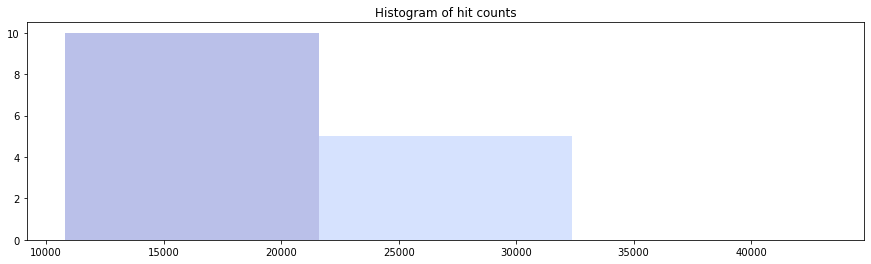

In [12]:
import matplotlib.pyplot as plt

class_breaks = world_map.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
max_values = []
colors = []
for class_break in class_breaks:
    max_values.append(class_break.classMaxValue)
    colors.append([color/255.0 for color in class_break.symbol.color])

# adjust bin for last class break
eps = 1e-1
max_values[-1] += 2*eps
    
# build a histogram for the same class breaks
plt.figure(figsize=(15,4))
n, bins, patches = plt.hist(grid_featureset.sdf['hitCount'], bins=max_values)

# apply the same color for each class to match the map
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)
    
plt.title('Histogram of hit counts')

In [13]:
isin_toptwo = grid_featureset.sdf['hitCount']>=max_values[-3]
grid_featureset.sdf[isin_toptwo]

,hitCount,OBJECTID,SHAPE
20,43180,21,"{""rings"": [[[3962492.1572117545, 3759028.54161..."


## Calculate statistics

In [14]:
def sum_missing_values(acled_data):
    return acled_data[['location', 'country', 'admin1', 'admin2', 'admin3']].isnull().sum()

def sum_by_fatalities(acled_data):
    """Group by drops None values!"""
    return acled_data.groupby(['location', 'country'])['fatalities'].sum().nlargest(5)

def count_by_event_types(acled_data):
    """Group by drops None values!"""
    sizes = size_by_locations(acled_data)
    min_size = sizes[-1]
    #return acled_data.groupby(['location', 'country']).apply(lambda group: group['event_type'].unique() if min_size <= len(group) else None ) 
    return acled_data.groupby(['location', 'country']).filter(lambda group: min_size <= len(group))['event_type'].value_counts()

def size_by_country(acled_data):
    """Group by drops None values!"""
    return acled_data.groupby(['country']).size().nlargest(5)

def size_by_locations(acled_data):
    """Group by drops None values!"""
    return acled_data.groupby(['location', 'country']).size().nlargest(5)

def print_stats(acled_data):
    print('5 most named countries:')
    print(size_by_country(acled_data))
    print()
    print('5 most named locations:')
    print(size_by_locations(acled_data))
    print()
    print('Event types of the 5 most named locations:')
    print(count_by_event_types(acled_data))
    print()
    print('5 most fatalities:')
    print(sum_by_fatalities(acled_data))
    print()
    print('Missing location values:')
    print(sum_missing_values(acled_data))
    print()

def print_value_counts(acled_data):
    print('Location:')
    print(acled_data['location'].value_counts())
    print()
    print('Country:')
    print(acled_data['country'].value_counts())
    print()
    print('Admin1:')
    print(acled_data['admin1'].value_counts())
    print()
    print('Admin2:')
    print(acled_data['admin2'].value_counts())
    print()
    print('Admin3:')
    print(acled_data['admin3'].value_counts())
    print()

#print_value_counts(acled_data)
print_stats(acled_data)
#acled_data['event_type'].unique()

5 most named countries:
country
Syria          72606
India          70268
Pakistan       55127
Yemen          46666
Afghanistan    42110
dtype: int64

5 most named locations:
location   country 
Karachi    Pakistan    3700
Hyderabad  Pakistan    2938
Peshawar   Pakistan    2158
Larkana    Pakistan    2110
Jammu      India       2108
dtype: int64

Event types of the 5 most named locations:
Protests                      10558
Violence against civilians      809
Riots                           554
Explosions/Remote violence      527
Battles                         453
Strategic developments          113
Name: event_type, dtype: int64

5 most fatalities:
location   country                     
Mosul      Iraq                            10670
Luena      Angola                           5490
El Fasher  Sudan                            4998
Maiduguri  Nigeria                          4981
Bunia      Democratic Republic of Congo     4806
Name: fatalities, dtype: int64

Missing location values:

In [15]:
acled_data_geodetailed = acled_data[acled_data['geo_precision'] == 1]
print_stats(acled_data_geodetailed)
#print_value_counts(acled_data_geodetailed)

5 most named countries:
country
India       56796
Syria       53380
Pakistan    46993
Yemen       26986
Somalia     25276
dtype: int64

5 most named locations:
location   country 
Hyderabad  Pakistan    2806
Karachi    Pakistan    2644
Jammu      India       2052
Peshawar   Pakistan    2018
Larkana    Pakistan    2006
dtype: int64

Event types of the 5 most named locations:
Protests                      9244
Violence against civilians     778
Riots                          513
Explosions/Remote violence     495
Battles                        408
Strategic developments          88
Name: event_type, dtype: int64

5 most fatalities:
location          country    
Mosul             Iraq           7866
Mosul - Al-Rabee  Iraq           4736
Maiduguri         Nigeria        4177
Mogadishu         Somalia        3853
Pibor             South Sudan    3548
Name: fatalities, dtype: int64

Missing location values:
location         0
country          0
admin1           0
admin2        5082
admin3   

In [16]:
acled_data_demonstrations = acled_data[(acled_data['event_type'] == 'Protests') | (acled_data['event_type'] == 'Riots')]
print_stats(acled_data_demonstrations)

5 most named countries:
country
India           61754
Pakistan        41612
Bangladesh      12098
South Africa    10806
Iran             5633
dtype: int64

5 most named locations:
location   country 
Hyderabad  Pakistan    2858
Karachi    Pakistan    2646
Larkana    Pakistan    2071
Jammu      India       2067
Lahore     Pakistan    1659
dtype: int64

Event types of the 5 most named locations:
Protests    10690
Riots         611
Name: event_type, dtype: int64

5 most fatalities:
location           country                     
Jos                Nigeria                         1859
Cairo-Nasr City 1  Egypt                            927
Aru                Democratic Republic of Congo     803
Khartoum           Sudan                            525
Cairo              Egypt                            485
Name: fatalities, dtype: int64

Missing location values:
location        0
country         0
admin1          0
admin2       2683
admin3      68100
dtype: int64



In [17]:
from arcgis.features import GeoAccessor
from geoint import geospatial

def assign_points(acled_data):
    with geospatial.geospatial_engine_factory.create_cloud_engine() as geospatial_engine:
        points = geospatial_engine.create_points(acled_data['latitude'], acled_data['longitude'])
        WGS84 = 4326
        WEB_MERCATOR = 3857
        mercator_points = geospatial_engine.project(points, WGS84, WEB_MERCATOR)
        x = [mercator_point.x for mercator_point in mercator_points]
        y = [mercator_point.y for mercator_point in mercator_points]
        return acled_data.assign(x=x, y=y)

def aggregate_locations(acled_data_spatial, area_data):
    grid_locations = []
    for index, area_row in area_data.iterrows():
        area_envelope = area_row['SHAPE'].envelope
        grid_location = { 
            'hitCount': area_row['hitCount'], 
            'locations': acled_data_spatial[(area_envelope.xmin <= acled_data_spatial['x']) \
                                            & (acled_data_spatial['x'] <= area_envelope.xmax) \
                                            & (area_envelope.ymin <= acled_data_spatial['y']) \
                                            & (acled_data_spatial['y'] <= area_envelope.ymax) \
                                           ]
        }           
        grid_locations.append(grid_location)
    
    return grid_locations
    
def locations_in_areas(acled_data, latitudes, longitudes, area_data):
    with geospatial.geospatial_engine_factory.create_cloud_engine() as geospatial_engine:
        points = geospatial_engine.create_points(latitudes, longitudes)
        WGS84 = 4326
        WEB_MERCATOR = 3857
        mercator_points = geospatial_engine.project(points, WGS84, WEB_MERCATOR)
    
    grid_locations = []
    for index, area_row in area_data.iterrows():
        area_envelope = area_row['SHAPE'].envelope
        grid_location = { 
            'hitCount': area_row['hitCount'], 
            'locations': dict()
        }
        for index in range(0, len(mercator_points)):
            location = acled_data['location'][index]
            if not location in grid_location['locations']:
                mercator_point = mercator_points[index]
                if area_envelope.xmin <= mercator_point.x \
                and mercator_point.x <= area_envelope.xmax \
                and area_envelope.ymin <= mercator_point.y \
                and mercator_point.y <= area_envelope.ymax:
                    location_entry = {
                        'location': location,
                        'country': acled_data['country'][index],
                        'admin1': acled_data['admin1'][index],
                        'admin2': acled_data['admin2'][index],
                        'admin3': acled_data['admin3'][index],
                        'geometry': mercator_point
                    }
                    grid_location['locations'][location] = location_entry
                    
        grid_locations.append(grid_location)
    
    return grid_locations

#acled_data_spatial = assign_points(acled_data)
acled_data_spatial = assign_points(acled_data_demonstrations)
area_data = grid_featureset.sdf.nlargest(3, 'hitCount')[['hitCount', 'SHAPE']]
aggregated_locations = aggregate_locations(acled_data_spatial, area_data)
#locations_in_areas(acled_data, latitudes, longitudes, area_data)

In [18]:
aggregated_locations[0]['locations']

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3,x,y
219,6759879,422,LBN3622,3622,25 January 2020,2020,1,Protests,Peaceful protest,Protesters (Lebanon),...,35.8497,1,An-Nahar,National,"On January 25, a march was held in Tripoli fro...",0,1580149675,LBN,3.990770e+06,4.087592e+06
399,6760016,422,LBN3604,3604,24 January 2020,2020,1,Protests,Peaceful protest,Protesters (Lebanon),...,35.8142,1,Murr TV,National,"On January 24, a demonstration was held outsid...",0,1580149676,LBN,3.986819e+06,4.089536e+06
426,6763618,760,SYR74576,74576,24 January 2020,2020,1,Protests,Peaceful protest,Protesters (Syria),...,36.3040,1,SOHR; Liveuamap,Local partner-New media,"On 24 January 2020, residents of Hrak town in ...",0,1580161640,SYR,4.041343e+06,3.862260e+06
446,6760051,422,LBN3603,3603,24 January 2020,2020,1,Protests,Peaceful protest,Protesters (Lebanon),...,35.8497,1,Murr TV,National,"On January 24, protesters of the revolution ag...",0,1580149676,LBN,3.990770e+06,4.087592e+06
805,6760043,422,LBN3608,3608,23 January 2020,2020,1,Protests,Peaceful protest,Protesters (Lebanon),...,36.1311,1,Murr TV,National,"On January 23, students in Deir al-Ahmar held ...",0,1580149676,LBN,4.022096e+06,4.045639e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477944,5362097,422,LBN488,488,16 January 2016,2016,1,Protests,Peaceful protest,Protesters (Lebanon),...,35.6192,1,National News Agency Lebanon,National,Women protesters asked for amnesty for their r...,0,1561470066,LBN,3.965111e+06,4.013116e+06
477946,5362098,422,LBN489,489,16 January 2016,2016,1,Protests,Peaceful protest,Protesters (Lebanon),...,35.8497,1,National News Agency Lebanon,National,The families of Islamist inmates at Roumieh ja...,0,1561470066,LBN,3.990770e+06,4.087592e+06
478148,5362094,422,LBN485,485,15 January 2016,2016,1,Protests,Peaceful protest,Protesters (Lebanon),...,35.8811,1,National News Agency Lebanon,National,Protesters held a sit-in held in al-Marj town ...,0,1561470066,LBN,3.994266e+06,3.996956e+06
478311,5362090,422,LBN481,481,14 January 2016,2016,1,Riots,Violent demonstration,Rioters (Lebanon),...,35.8497,1,National News Agency Lebanon,National,Tabbaneh-Qobbeh road in Tripoli was blocked Th...,0,1561470066,LBN,3.990770e+06,4.087592e+06


In [35]:
acled_data_demonstrations = acled_data[(acled_data['event_type'] == 'Protests') | (acled_data['event_type'] == 'Riots')]

In [63]:
unique_counts = acled_data_demonstrations.groupby(['latitude', 'longitude']).location.transform('nunique')
acled_data_demonstrations[1 < unique_counts].groupby(['latitude', 'longitude', unique_counts]).location.unique()
#value_counts
#value_counts[value_counts.groupby(level=1).transform('nunique').gt(1)]
#acled_data[(acled_data['latitude'] == -54.8062) & (acled_data['longitude'] == -68.3102)]

latitude  longitude  location
-33.9473   18.5751   2                    [Cape Town - Bishop Lavis, Bishop Lavis]
-33.9000   18.6333   2                          [Cape Town - Bellville, Bellville]
-26.4164   27.8650   2                         [Johannesburg - Pinetown, Pinetown]
-26.2667   27.8667   2                             [Johannesburg - Soweto, Soweto]
-25.9957   28.1971   2           [Johannesburg - Midrand, Johannesburg - Ivory ...
-22.9064  -43.1822   2             [Rio de Janeiro - Central Zone, Rio de Janeiro]
 13.9315   75.5679   2                                       [Shimoga, Shivamogga]
 15.8521   74.5044   2                                         [Belagavi, Belgaum]
 16.0633  -95.3919   2           [Santa Gertudris Miramar, Santa Gertrudis Mira...
 23.3965   84.1066   2                                          [Regai, Mahuadanr]
 23.4116   84.1145   2                                             [Bohta, Rampur]
 24.8979   66.9933   2                              [Kara